In [1]:
!nvidia-smi

Wed Dec 11 19:41:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.09                 Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   50C    P8             16W /   70W |     495MiB /   6144MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
!pip install torchmetrics

In [10]:
!pip install pycocotools

# Image captioning Transformer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from tqdm.notebook import trange, tqdm
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.distributions import Categorical

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision

from torchmetrics.text import BLEUScore

#from torchsummary import summary

import time

import wandb

from transformers import AutoTokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.backends.cuda.matmul.allow_tf32 = True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
data_set_root= r'data/coco2017'
train_set ='train2017'
validation_set ='val2017'
test_set = 'test2017'

train_image_path = os.path.join(data_set_root, train_set)
train_ann_file = '{}/annotations/captions_{}.json'.format(data_set_root, train_set)

val_image_path = os.path.join(data_set_root, validation_set)
val_ann_file = '{}/annotations/captions_{}.json'.format(data_set_root, validation_set)

test_image_path = os.path.join(data_set_root, test_set)

## parameters 

In [5]:
image_size = 128

batch_size = 128

# Data processing

In [6]:
# Simple transform class to randomly sample one of the five captions
class SampleCaption(nn.Module):
    def __call__(self, sample):
        rand_index = random.randint(0, len(sample) - 1)
        return sample[rand_index]

In [7]:
train_transform = transforms.Compose([transforms.Resize(image_size),
                                      transforms.RandomCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225]),
                                      transforms.RandomErasing(p=0.5)])

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

train_dataset = datasets.CocoCaptions(root=train_image_path,
                                      annFile=train_ann_file,
                                      transform=train_transform,
                                      target_transform=SampleCaption())

val_dataset = datasets.CocoCaptions(root=val_image_path,
                                    annFile=val_ann_file,
                                    transform=transform,
                                    target_transform=SampleCaption())

data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
data_loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [7]:
print(len(data_loader_val)) 

40


In [8]:
print(len(data_loader_train)) 

925


In [9]:
data = data_loader_val.dataset[0]  # Access the first item
print(data)

(tensor([[[ 0.9303,  0.9303,  0.9132,  ...,  0.6221,  0.6221,  0.5878],
         [ 0.9303,  0.9474,  0.9303,  ...,  0.6221,  0.6049,  0.6049],
         [ 0.9303,  0.9474,  0.9303,  ...,  0.6392,  0.6221,  0.5878],
         ...,
         [ 0.6392,  0.6221,  0.6049,  ...,  0.3823,  0.4851,  0.6049],
         [ 0.5364,  0.5878,  0.5707,  ...,  0.5193,  0.5193,  0.6392],
         [ 0.4679,  0.5536,  0.5193,  ...,  0.3652,  0.3823,  0.5193]],

        [[ 0.4328,  0.3978,  0.3627,  ...,  0.1176,  0.0476, -0.0224],
         [ 0.4853,  0.4678,  0.4328,  ...,  0.1001,  0.0651,  0.0126],
         [ 0.5203,  0.5028,  0.5028,  ...,  0.0651,  0.0476, -0.0049],
         ...,
         [-0.9503, -0.9503, -0.9678,  ..., -0.9328, -0.8803, -0.8102],
         [-0.9853, -0.9678, -1.0028,  ..., -1.0203, -0.9678, -0.8978],
         [-1.0728, -1.0028, -1.0378,  ..., -1.1253, -1.0903, -1.0028]],

        [[-0.7238, -0.7238, -0.7413,  ..., -0.5670, -0.6018, -0.6018],
         [-0.7064, -0.7238, -0.7413,  ..., -

In [ ]:
dataiter = next(iter(DataLoader(val_dataset, batch_size=1)))
print(dataiter)
#val_images, val_captions = dataiter


[tensor([[[[ 0.9303,  0.9303,  0.9132,  ...,  0.6221,  0.6221,  0.5878],
          [ 0.9303,  0.9474,  0.9303,  ...,  0.6221,  0.6049,  0.6049],
          [ 0.9303,  0.9474,  0.9303,  ...,  0.6392,  0.6221,  0.5878],
          ...,
          [ 0.6392,  0.6221,  0.6049,  ...,  0.3823,  0.4851,  0.6049],
          [ 0.5364,  0.5878,  0.5707,  ...,  0.5193,  0.5193,  0.6392],
          [ 0.4679,  0.5536,  0.5193,  ...,  0.3652,  0.3823,  0.5193]],

         [[ 0.4328,  0.3978,  0.3627,  ...,  0.1176,  0.0476, -0.0224],
          [ 0.4853,  0.4678,  0.4328,  ...,  0.1001,  0.0651,  0.0126],
          [ 0.5203,  0.5028,  0.5028,  ...,  0.0651,  0.0476, -0.0049],
          ...,
          [-0.9503, -0.9503, -0.9678,  ..., -0.9328, -0.8803, -0.8102],
          [-0.9853, -0.9678, -1.0028,  ..., -1.0203, -0.9678, -0.8978],
          [-1.0728, -1.0028, -1.0378,  ..., -1.1253, -1.0903, -1.0028]],

         [[-0.7238, -0.7238, -0.7413,  ..., -0.5670, -0.6018, -0.6018],
          [-0.7064, -0.7238, 

In [8]:
# Create a dataloader itterable object
dataiter = next(iter(data_loader_val))
# Sample from the itterable object
val_images, val_captions = dataiter

Two buses and a taxi go down a street,


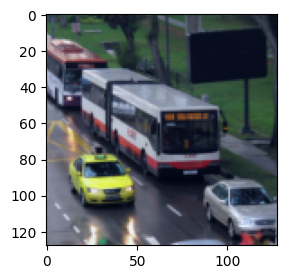

In [9]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(val_images[0:1], 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

caption = val_captions[0]
print(caption)

In [10]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [11]:
tokenizer.vocab_size

30522

In [12]:
tokens = tokenizer(val_captions, padding=True, truncation=True, return_tensors="pt")

In [13]:
tokens['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [14]:
token_ids = tokens['input_ids'][0]
tokens['input_ids']

tensor([[  101,  2048,  7793,  ...,     0,     0,     0],
        [  101,  1037, 10733,  ...,     0,     0,     0],
        [  101,  2111,  3666,  ...,     0,     0,     0],
        ...,
        [  101,  2048, 21443,  ...,     0,     0,     0],
        [  101,  1037,  5430,  ...,     0,     0,     0],
        [  101,  2111,  1999,  ...,     0,     0,     0]])

In [15]:
print(tokenizer.decode(token_ids))

[CLS] two buses and a taxi go down a street, [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


# Model

## Positional embedding

In [16]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

## Encoder

In [18]:
def extract_patches(image_tensor, patch_size=16):
    # Get the dimensions of the image tensor
    b, c, h, w = image_tensor.size()

    # Define the Unfold layer with appropriate parameters
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)

    # Apply Unfold to the image tensor
    unfolded = unfold(image_tensor)

    # Reshape the unfolded tensor to match the desired output shape
    # Output shape: BxLxH, where L is the number of patches in each dimension
    unfolded = unfolded.transpose(1, 2).reshape(b, -1, c * patch_size * patch_size)

    return unfolded

In [19]:
class Encoder(nn.Module): #base on VIT
    def __init__(self, image_size, channels_in, patch_size=16, hidden_size=128,
                 num_layers=3, num_heads=4):
        super(Encoder, self).__init__()

        self.patch_size = patch_size
        self.fc_in = nn.Linear(channels_in * patch_size * patch_size, hidden_size)

        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length,
                                                      hidden_size).normal_(std=0.02))

        # Create multiple transformer blocks as layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dim_feedforward= hidden_size*4, 
                                                   batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=num_layers)


    def forward(self, image):
        b = image.shape[0]

        patch_seq = extract_patches(image, patch_size=self.patch_size)
        patch_emb = self.fc_in(patch_seq)

        # Add a unique embedding to each token embedding
        embs = patch_emb + self.pos_embedding

        # Pass the embeddings through each transformer block
        output = self.transformer_encoder(embs)

        return output


In [ ]:
from transformers import ViTModel

print(device)

class ImageEmbedding(nn.Module):
    def __init__(self, vit_model="google/vit-base-patch16-224-in21k"):
        super(ImageEmbedding, self).__init__()
        self.vit = ViTModel.from_pretrained(vit_model)

        self.vit = self.vit.to(device)
        
        # Use only the patch embedding layer
        self.patch_embed = self.vit.embeddings.patch_embeddings
        self.register_buffer("pos_embed", self.vit.embeddings.position_embeddings[:, 1:], persistent=False) # Ignore CLS position

        self.linear_proj = nn.Linear(768, hidden_size)

    def forward(self, images):

        pos_embed = self.pos_embed
        
        # Extract patch embeddings
        patch_embeds = self.patch_embed(images)
        
        # Add positional embeddings
        embs = patch_embeds + pos_embed

        embs = self.linear_proj(embs)

        #embs = embs.to(device)
        
        return embs

In [ ]:
class Encoder2(nn.Module): #base on VIT
    def __init__(self, hidden_size=768, num_layers=3, num_heads=4):
        super(Encoder2, self).__init__()

        self.image_embedding = ImageEmbedding()

        # Create multiple transformer blocks as layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dim_feedforward= hidden_size*4, 
                                                   batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=num_layers)


    def forward(self, image):
        b = image.shape[0]

        embs = self.image_embedding(image)

        # Pass the embeddings through each transformer block
        output = self.transformer_encoder(embs)

        return output

## Decoder

In [20]:
class Decoder(nn.Module): #base on BERT
    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(Decoder, self).__init__()

        # Create an embedding layer for tokens
        self.embedding = nn.Embedding(num_emb, hidden_size)
        # Initialize the embedding weights
        self.embedding.weight.data = 0.001 * self.embedding.weight.data

        # Initialize sinusoidal positional embeddings
        self.pos_emb = SinusoidalPosEmb(hidden_size)

        # Create multiple transformer blocks as layers
        decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads,dim_feedforward= hidden_size*4, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Define a linear layer for output prediction
        self.fc_out = nn.Linear(hidden_size, num_emb)

        #self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_seq, encoder_output, input_padding_mask=None,
                encoder_padding_mask=None):
        # Embed the input sequence
        input_embs = self.embedding(input_seq)
        b, l, h = input_embs.shape

        # Add positional embeddings to the input embeddings
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(b, l, h)
        embs = input_embs + pos_emb

        # Generate the causal mask
        attn_mask = nn.Transformer.generate_square_subsequent_mask(l).to(input_seq.device).bool()


        # Pass the embeddings through each transformer block
        output = self.transformer_decoder(tgt = embs, memory=encoder_output, memory_mask=None, tgt_mask=attn_mask,
                                          tgt_key_padding_mask=input_padding_mask, memory_key_padding_mask=encoder_padding_mask,
                                          tgt_is_causal=True, memory_is_causal=False)

        output = self.fc_out(output)
        
        return output

In [ ]:
from transformers import DistilBertModel

class TextEmbedding(nn.Module):
    def __init__(self, bert_model="distilbert-base-uncased"):
        super(TextEmbedding, self).__init__()
        self.bert = DistilBertModel.from_pretrained(bert_model)

        self.bert = self.bert.to(device)
        
        # Extract word and positional embeddings
        self.embedding = self.bert.embeddings.word_embeddings
        self.positional_embedding = self.bert.embeddings.position_embeddings

        self.linear_proj = nn.Linear(768, hidden_size)

    def forward(self, tokens):
        word_embs =  self.embedding(tokens)

        pos_embs = self.positional_embedding(torch.arange(tokens.size(1), device=tokens.device))
        
        # Word and positional embeddings already combined
        text_embeds = word_embs + pos_embs 

        text_embeds = self.linear_proj(text_embeds)

        #text_embeds = text_embeds.to(device)
        return text_embeds

In [ ]:
class Decoder2(nn.Module): #base on BERT
    def __init__(self, num_emb, hidden_size=768, num_layers=3, num_heads=4):
        super(Decoder2, self).__init__()

        self.embedding = TextEmbedding()

        # Create multiple transformer blocks as layers
        decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads,dim_feedforward= hidden_size*4, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Define a linear layer for output prediction
        self.fc_out = nn.Linear(hidden_size, num_emb)


    def forward(self, input_seq, encoder_output, input_padding_mask=None,
                encoder_padding_mask=None):
        # Embed the input sequence
        input_embs = self.embedding(input_seq)
        l = input_embs.size(1)

        # Generate the causal mask
        attn_mask = nn.Transformer.generate_square_subsequent_mask(l).to(input_seq.device).bool()

        # Pass the embeddings through each transformer block
        output = self.transformer_decoder(tgt = input_embs, memory=encoder_output, memory_mask=None, tgt_mask=attn_mask,
                                          tgt_key_padding_mask=input_padding_mask, memory_key_padding_mask=encoder_padding_mask,
                                          tgt_is_causal=True, memory_is_causal=False)
        output = self.fc_out(output)

        return output

## Encode-Decoder

In [21]:
class EncoderDecoder(nn.Module):
    def __init__(self, image_size, channels_in, num_emb, patch_size=16,
                 hidden_size=128, num_layers=(3, 3), num_heads=4):
        super(EncoderDecoder, self).__init__()

        # Create an encoder and decoder with specified parameters
        self.encoder = Encoder(image_size=image_size, channels_in=channels_in,
                                     patch_size=patch_size, hidden_size=hidden_size,
                                     num_layers=num_layers[0], num_heads=num_heads)

        self.decoder = Decoder(num_emb=num_emb, hidden_size=hidden_size,
                               num_layers=num_layers[1], num_heads=num_heads)

    def forward(self, input_image, target_seq, attention_mask):
        # Generate padding masks for the target sequence
        bool_padding_mask = attention_mask == 0

        # Encode the input sequence
        encoded_seq = self.encoder(image=input_image)

        # Decode the target sequence using the encoded sequence
        decoded_seq = self.decoder(input_seq=target_seq,
                                   encoder_output=encoded_seq,
                                   input_padding_mask=bool_padding_mask)
        return decoded_seq

In [ ]:
class EncoderDecoder2(nn.Module):
    def __init__(self, num_emb,
                 hidden_size=768, num_layers=(3, 3), num_heads=4):
        super(EncoderDecoder2, self).__init__()

        # Create an encoder and decoder with specified parameters
        self.encoder = Encoder2(hidden_size=hidden_size,
                                     num_layers=num_layers[0], num_heads=num_heads)

        self.decoder = Decoder2(num_emb=num_emb, hidden_size=hidden_size,
                               num_layers=num_layers[1], num_heads=num_heads)

    def debug_device_check(self):
        has_printed = False
        for name, param in self.named_parameters():
            if not has_printed:
                print(f"Model device check:")
                has_printed = True
            print(f"{name}: {param.device}")
    
        if not has_printed:
            print("No parameters found!")

    def forward(self, input_image, target_seq, attention_mask):
        # Generate padding masks for the target sequence
        bool_padding_mask = attention_mask == 0

        #bool_padding_mask = bool_padding_mask.to(device)

        # Encode the input sequence
        encoded_seq = self.encoder(image=input_image)

        # Decode the target sequence using the encoded sequence
        decoded_seq = self.decoder(input_seq=target_seq,
                                   encoder_output=encoded_seq,
                                   input_padding_mask=bool_padding_mask)
        
        return decoded_seq

# Pretrain Model 

## Encoder

In [ ]:
from transformers import ViTModel, ViTConfig

class ImageEncoder(nn.Module):
    def __init__(self, pretrained_model="google/vit-base-patch16-224-in21k"):
        super(ImageEncoder, self).__init__()
        self.vit = ViTModel.from_pretrained(pretrained_model)

    def forward(self, images):
        vit_output = self.vit(pixel_values=images)
        return vit_output.last_hidden_state


## Decoder

In [ ]:
from transformers import DistilBertModel

class CaptionDecoder(nn.Module):
    def __init__(self, pretrained_model="distilbert-base-uncased"):
        super(CaptionDecoder, self).__init__()
        self.bert = DistilBertModel.from_pretrained(pretrained_model)

    def forward(self, tokens, encoder_outputs, attention_mask):
        tokens = tokens.to(encoder_outputs.device)

        # Pass through BERT, using image features as encoder outputs
        outputs = self.bert(
            input_ids=tokens,
            encoder_hidden_states=encoder_outputs,
            encoder_attention_mask=attention_mask
        )
        return outputs.last_hidden_state

## Encoder-Decoder

In [ ]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, vit_model="google/vit-base-patch16-224-in21k",
                 bert_model="distilbert-base-uncased"):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = ImageEncoder(pretrained_model=vit_model)
        self.decoder = CaptionDecoder(pretrained_model=bert_model)

    def forward(self, images, tokens, attention_mask):
        device = images.device  # Ensure both the images and tokens are on the same device
        encoder_outputs = self.encoder(images.to(device))
        decoder_outputs = self.decoder(tokens.to(device), encoder_outputs, attention_mask)
        return decoder_outputs

    # Move the whole model to the device
    def to(self, device):
        self.encoder.vit.to(device)
        self.decoder.bert.to(device)
        return super().to(device)

# Hyper Parameters

In [28]:
learning_rate = 1e-4

epochs = 200

model_path = 'model/transf_model.pth'

In [23]:
hidden_size = 192

# Number of Transformer blocks for the (Encoder, Decoder)
num_layers = (6, 6)

# MultiheadAttention Heads
num_heads = 8

# Size of the patches
patch_size = 8

In [ ]:
model = EncoderDecoder(image_size=image_size, channels_in=val_images.shape[1],
                                     num_emb=tokenizer.vocab_size, patch_size=patch_size,
                                     num_layers=num_layers,hidden_size=hidden_size,
                                     num_heads=num_heads)

#model = nn.DataParallel(model, device_ids=[0, 1])
model = model.to(device)

#summary(model, (3, 256, 256))

AssertionError: Invalid device id

In [25]:
print(torch.cuda.is_available()) 

True


# Training

## Wandb para

In [ ]:
PROJECT = "Image_Captioning"
RESUME = "allow"
WANDB_KEY = "d9d14819dddd8a35a353b5c0b087e0f60d717140"

## Set up

In [ ]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token.

    Args:
        prob (float): probability of dropping a token
        blank_token (int): index for the blank token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, blank_token=1, eos_token=102):
        self.prob = prob
        self.eos_token = eos_token
        self.blank_token = blank_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p=prob
        # to create a mask where 1 means we will replace that token
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()

        # only replace if the token is not the eos token
        can_drop = (~(sample == self.eos_token)).long()
        mask = mask * can_drop

        # Do not replace the sos tokens
        mask[:, 0] = torch.zeros_like(mask[:, 0]).long()

        replace_with = (self.blank_token * torch.ones_like(sample)).long()

        sample_out = (1 - mask) * sample + mask * replace_with

        return sample_out

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scaler = torch.cuda.amp.GradScaler()

loss_fn = nn.CrossEntropyLoss(reduction="none")

td = TokenDrop(0.5)


In [ ]:
wandb.login(
    key = "d9d14819dddd8a35a353b5c0b087e0f60d717140",
)

In [ ]:
wandb.init(
    project=PROJECT,
    resume=RESUME,
    name="init_transformer2",
    config={
        "learning_rate": learning_rate,
        "epochs": epochs,
        "batch_size": batch_size,
    },
)
wandb.watch(model)

## Train

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1, verbose=True)

In [ ]:
# Early stopping parameters
patience = 15  # Number of epochs to wait for improvement
counter = 0   # Counter to track the number of epochs without improvement
best_val_loss = float('inf')  # Initialize the best validation loss
best_epoch = 0  # Track the epoch when the best model was found
bleu_metric = BLEUScore(n_gram=4, smooth=True).to(device)

def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    # Iterate over the training data loader
    for images, captions in tqdm(dataloader, desc="Training", leave=False):
        images = images.to(device)

        # Tokenize and pre-process the captions
        tokens = tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
        token_ids = tokens['input_ids'].to(device)
        padding_mask = tokens['attention_mask'].to(device)
        b = token_ids.shape[0]

        # Shift right the input sequence to create the target sequence
        target_ids = torch.cat((token_ids[:, 1:], torch.zeros(b, 1, device=device).long()), 1).to(device)

        tokens_in = td(token_ids).to(device)
        
        with torch.cuda.amp.autocast():
            # Forward pass
            pred = model(images, tokens_in, attention_mask=padding_mask)
            loss = (loss_fn(pred.transpose(1, 2), target_ids) * padding_mask).mean()

        # Backpropagation
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    return epoch_loss

def validate_epoch(model, dataloader, loss_fn, device):
    model.eval()
    total_val_loss = 0
    bleu_metric.reset()  # Reset BLEU metric before validation

    with torch.no_grad():
        for images, captions in tqdm(dataloader, desc="Validation", leave=False):
            images = images.to(device)
            tokens = tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
            token_ids = tokens['input_ids'].to(device)
            padding_mask = tokens['attention_mask'].to(device)
            b = token_ids.shape[0]

            target_ids = torch.cat((token_ids[:, 1:], torch.zeros(b, 1, device=device).long()), 1).to(device)
            tokens_in = td(token_ids).to(device)

            # Forward pass
            with torch.cuda.amp.autocast():
                pred = model(images, tokens_in, attention_mask=padding_mask)

            # Compute validation loss
            val_loss = (loss_fn(pred.transpose(1, 2), target_ids) * padding_mask).mean()
            total_val_loss += val_loss.item()

            # Decode predictions and targets
            pred_ids = torch.argmax(pred, dim=2)
            pred_texts = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
            target_texts = tokenizer.batch_decode(target_ids, skip_special_tokens=True)

            # Update BLEU score
            bleu_metric.update(pred_texts, target_texts)

    epoch_loss = total_val_loss / len(dataloader)
    avg_bleu_score = bleu_metric.compute()

    return [epoch_loss, avg_bleu_score]


for epoch in trange(0, epochs, leave=False, desc="Epoch"):
    start_time = time.time()

    train_loss = train_epoch(model, data_loader_train, optimizer, loss_fn, device)
    val_loss, val_bleu = validate_epoch(model, data_loader_val, loss_fn, device)

    scheduler.step(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Bleu_Score: {val_bleu:.4f}, Learning Rate: {current_lr:.8f}")

    # Check if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        counter = 0  # Reset counter if loss improved
        torch.save(model.state_dict(), model_path)
        print(f"New best checkpoint saved with val_loss: {val_loss:.4f}")
    else:
        counter += 1
        print(f"Validation loss did not improve. Counter: {counter}/{patience}")

    # Early stopping: stop training if no improvement after 'patience' epochs
    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Validation loss did not improve for {patience} epochs.")
        break

    # Log results to WandB
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "Bleu_Score": val_bleu,
        "learning_rate": current_lr,
    })

wandb.finish()

# Test

In [32]:
state_dict = torch.load(model_path)
from collections import OrderedDict

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "")  # remove 'module.' prefix
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)
model = model.to(device)


C:\Users\MY LAPTOP\AppData\Local\Temp\ipykernel_25168\3126991316.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


In [144]:
# # Create a dataloader itterable object
dataiter = next(iter(data_loader_val))
# # Sample from the itterable object
val_images, val_captions = dataiter

In [145]:
# Choose an index within the batch
index = 0
val_images = val_images[index].unsqueeze(0)

A man filming a person skateboarding on a wall.


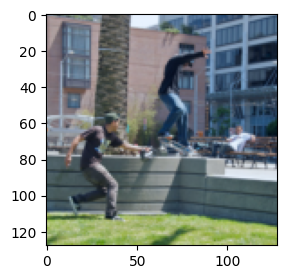

In [146]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(val_images, 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))
print(val_captions[index])

In [147]:
# Add the Start-Of-Sentence token to the prompt to signal the network to start generating the caption
sos_token = 101 * torch.ones(1, 1).long()

# Set the temperature for sampling during generation
temp = 0.5

In [148]:
log_tokens = [sos_token]
model.eval()

with torch.no_grad():
    # Encode the input image
    with torch.cuda.amp.autocast():
        # Forward pass
        image_embedding = model.encoder(val_images.to(device))

    # Generate the answer tokens
    for i in range(50):
        input_tokens = torch.cat(log_tokens, 1)

        # Decode the input tokens into the next predicted tokens
        data_pred = model.decoder(input_tokens.to(device), image_embedding)

        # Sample from the distribution of predicted probabilities
        dist = Categorical(logits=data_pred[:, -1] / temp)
        next_tokens = dist.sample().reshape(1, 1)

        # Append the next predicted token to the sequence
        log_tokens.append(next_tokens.cpu())

        # Break the loop if the End-Of-Caption token is predicted
        if next_tokens.item() == 102:
            break

C:\Users\MY LAPTOP\AppData\Local\Temp\ipykernel_25168\4288229076.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


In [149]:
# Convert the list of token indices to a tensor
pred_text = torch.cat(log_tokens, 1)

# Convert the token indices to their corresponding strings using the vocabulary
pred_text_strings = tokenizer.decode(pred_text[0], skip_special_tokens=True)

# Join the token strings to form the predicted text
pred_text = "".join(pred_text_strings)

# Print the predicted text
print(pred_text)

a man riding a skateboard on a sidewalk.


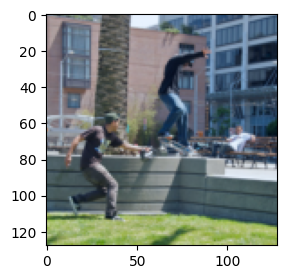

In [150]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(val_images, 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))